You can read an overview of this Numerical Linear Algebra course in [this blog post](http://www.fast.ai/2017/07/17/num-lin-alg/).  The course was originally taught in the [University of San Francisco MS in Analytics](https://www.usfca.edu/arts-sciences/graduate-programs/analytics) graduate program.  Course lecture videos are [available on YouTube](https://www.youtube.com/playlist?list=PLtmWHNX-gukIc92m1K0P6bIOnZb-mg0hY) (note that the notebook numbers and video numbers do not line up, since some notebooks took longer than 1 video to cover).

You can ask questions about the course on [our fast.ai forums](http://forums.fast.ai/c/lin-alg).

# 7. How to Implement Linear Regression

In the previous lesson, we calculated the least squares linear regression for a diabetes dataset, using scikit learn's implementation.  Today, we will look at how we could write our own implementation.

In [1]:
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import math, scipy, numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=6)

In [3]:
data = datasets.load_diabetes()

In [4]:
data.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [5]:
feature_names=['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [6]:
trn,test,y_trn,y_test = train_test_split(data.data, data.target, test_size=0.2)

In [7]:
trn.shape, test.shape

((353, 10), (89, 10))

In [8]:
def regr_metrics(act, pred):
    return (math.sqrt(metrics.mean_squared_error(act, pred)), 
     metrics.mean_absolute_error(act, pred))

### How did sklearn do it?

How is sklearn doing this?  By checking [the source code](https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/linear_model/base.py#L417), you can see that in the dense case, it calls [scipy.linalg.lstqr](https://github.com/scipy/scipy/blob/v0.19.0/scipy/linalg/basic.py#L892-L1058), which is calling a LAPACK method:

        Options are ``'gelsd'``, ``'gelsy'``, ``'gelss'``. Default
        (``'gelsd'``) is a good choice.  However, ``'gelsy'`` can be slightly
        faster on many problems.  ``'gelss'`` was used historically.  It is
        generally slow but uses less memory.

- [gelsd](https://software.intel.com/sites/products/documentation/doclib/mkl_sa/11/mkl_lapack_examples/_gelsd.htm): uses SVD and a divide-and-conquer method
- [gelsy](https://software.intel.com/en-us/node/521113): uses QR factorization
- [gelss](https://software.intel.com/en-us/node/521114): uses SVD

#### Scipy Sparse Least Squares

We will not get into too much detail about the sparse version of least squares.  Here is a bit of info if you are interested: 

[Scipy sparse lsqr](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.lsqr.html#id1) uses an iterative method called [Golub and Kahan bidiagonalization](https://web.stanford.edu/class/cme324/paige-saunders2.pdf).

from [scipy sparse lsqr source code](https://github.com/scipy/scipy/blob/v0.14.0/scipy/sparse/linalg/isolve/lsqr.py#L96):
  Preconditioning is another way to reduce the number of iterations. If it is possible to solve a related system ``M*x = b`` efficiently, where M approximates A in some helpful way (e.g. M - A has low rank or its elements are small relative to those of A), LSQR may converge more rapidly on the system ``A*M(inverse)*z = b``, after which x can be recovered by solving M\*x = z.
  
If A is symmetric, LSQR should not be used! Alternatives are the symmetric conjugate-gradient method (cg) and/or SYMMLQ.  SYMMLQ is an implementation of symmetric cg that applies to any symmetric A and will converge more rapidly than LSQR.  If A is positive definite, there are other implementations of symmetric cg that require slightly less work per iteration than SYMMLQ (but will take the same number of iterations).

### linalg.lstqr

The sklearn implementation handled adding a constant term (since the y-intercept is presumably not 0 for the line we are learning) for us.  We will need to do that by hand now:

In [9]:
trn_int = np.c_[trn, np.ones(trn.shape[0])]
test_int = np.c_[test, np.ones(test.shape[0])]

Since `linalg.lstsq` lets us specify which LAPACK routine we want to use, lets try them all and do some timing comparisons:

In [10]:
import time
def timecost(f, *arg, **kwang):
    t1 = time.time()
    x = eval(f)(*arg, **kwang)
    t2 = time.time()
    print(t2-t1)
    return x

In [11]:
#%timeit coef, _,_,_ = linalg.lstsq(trn_int, y_trn, lapack_driver="gelsd")
x = timecost('linalg.lstsq',trn_int, y_trn, lapack_driver="gelsd")
x = timecost('linalg.lstsq',trn_int, y_trn, lapack_driver="gelsy")
x = timecost('linalg.lstsq',trn_int, y_trn, lapack_driver="gelss")

0.008973360061645508
0.0009968280792236328
0.0


In [12]:
%timeit coef, _,_,_ = linalg.lstsq(trn_int, y_trn, lapack_driver="gelsy")

53.4 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [13]:
%timeit coef, _,_,_ = linalg.lstsq(trn_int, y_trn, lapack_driver="gelss")

101 µs ± 1.99 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Naive Solution

Recall that we want to find $\hat{x}$ that minimizes: 
$$ \big\vert\big\vert Ax - b \big\vert\big\vert_2$$

Another way to think about this is that we are interested in where vector $b$ is closest to the subspace spanned by $A$ (called the *range of* $A$).  This is the projection of $b$ onto $A$.  Since $b - A\hat{x}$ must be perpendicular to the subspace spanned by $A$, we see that

$$A^T (b - A\hat{x}) = 0 $$

(we are using $A^T$ because we want to multiply each column of $A$ by $b - A\hat{x}$

This leads us to the *normal equations*:
$$ x = (A^TA)^{-1}A^T b $$

In [14]:
def ls_naive(A, b):
     return np.linalg.inv(A.T @ A) @ A.T @ b

In [15]:
%timeit coeffs_naive = ls_naive(trn_int, y_trn)

25 µs ± 641 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


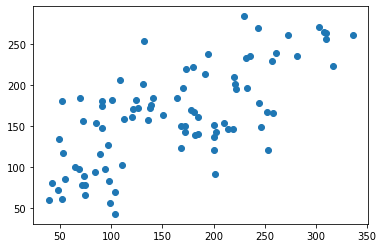

In [16]:
coeffs_naive = ls_naive(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_naive)
plt.scatter(y_test, test_int @ coeffs_naive)

### Normal Equations (Cholesky)

Normal equations:
$$ A^TA x = A^T b $$

If $A$ has full rank, the pseudo-inverse $(A^TA)^{-1}A^T$ is a **square, hermitian positive definite** matrix.  The standard way of solving such a system is *Cholesky Factorization*, which finds upper-triangular R s.t. $A^TA = R^TR$.

The following steps are based on Algorithm 11.1 from Trefethen:

In [17]:
A = trn_int

In [18]:
b = y_trn

In [19]:
AtA = A.T @ A
Atb = A.T @ b

**Warning:** Numpy and Scipy default to different upper/lower for Cholesky

In [20]:
R = scipy.linalg.cholesky(AtA)

In [21]:
np.set_printoptions(suppress=True, precision=4)
R

array([[ 0.8861,  0.1602,  0.176 ,  0.2846,  0.2509,  0.2139, -0.0673,
         0.1859,  0.2612,  0.2388, -0.4423],
       [ 0.    ,  0.8797,  0.0636,  0.1611, -0.0107,  0.0806, -0.3238,
         0.2639,  0.0994,  0.1557,  0.2627],
       [ 0.    ,  0.    ,  0.8836,  0.2688,  0.1912,  0.2152, -0.3152,
         0.3448,  0.3477,  0.2898, -0.5816],
       [ 0.    ,  0.    ,  0.    ,  0.7722,  0.0822,  0.0051,  0.0431,
        -0.001 ,  0.1512,  0.1571, -0.6007],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.8462,  0.7495,  0.1611,
         0.3686,  0.3227,  0.1557,  0.4795],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.3756, -0.4124,
         0.2771, -0.3267, -0.0388, -0.5479],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6207,
        -0.4836, -0.4984, -0.169 ,  0.6233],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.2993, -0.0212,  0.0353, -0.511 ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
 

check our factorization:

In [22]:
np.linalg.norm(AtA - R.T @ R)

5.347001966001931e-16

$$ A^T A x = A^T b $$
$$ R^T R x = A^T b $$
$$ R^T w = A^T b $$
$$ R x = w $$

In [23]:
w = scipy.linalg.solve_triangular(R, Atb, lower=False, trans='T')

It's always good to check that our result is what we expect it to be: (in case we entered the wrong params, the function didn't return what we thought, or sometimes the docs are even outdated)

In [24]:
np.linalg.norm(R.T @ w - Atb)

1.7053025658242404e-13

In [25]:
coeffs_chol = scipy.linalg.solve_triangular(R, w, lower=False)

In [26]:
np.linalg.norm(R @ coeffs_chol - w)

5.54951617168815e-14

In [27]:
def ls_chol(A, b):
    R = scipy.linalg.cholesky(A.T @ A)
    w = scipy.linalg.solve_triangular(R, A.T @ b, trans='T')
    return scipy.linalg.solve_triangular(R, w)

In [28]:
%timeit coeffs_chol = ls_chol(trn_int, y_trn)

51.1 µs ± 943 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [29]:
coeffs_chol = ls_chol(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_chol)

(55.473623995971415, 45.94603053243581)

### QR Factorization

$$ A x = b $$
$$ A = Q R $$
$$ Q R x = b $$

$$ R x = Q^T b $$

In [30]:
def ls_qr(A,b):
    Q, R = scipy.linalg.qr(A, mode='economic')
    return scipy.linalg.solve_triangular(R, Q.T @ b)

In [31]:
%timeit coeffs_qr = ls_qr(trn_int, y_trn)

98.8 µs ± 4.25 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [32]:
coeffs_qr = ls_qr(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_qr)

(55.473623995971415, 45.9460305324358)

### SVD

$$ A x = b $$

$$ A = U \Sigma V $$

$$ \Sigma V x = U^T b $$

$$ \Sigma w = U^T b $$

$$ x = V^T w $$

SVD gives the pseudo-inverse

In [33]:
def ls_svd(A,b):
    m, n = A.shape
    U, sigma, Vh = scipy.linalg.svd(A, full_matrices=False, lapack_driver='gesdd')
    w = (U.T @ b)/ sigma
    return Vh.T @ w

In [ ]:
%timeit coeffs_svd = ls_svd(trn_int, y_trn)

In [ ]:
%timeit coeffs_svd = ls_svd(trn_int, y_trn)

In [ ]:
coeffs_svd = ls_svd(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_svd)

### Random Sketching Technique for Least Squares Regression

[Linear Sketching](http://researcher.watson.ibm.com/researcher/files/us-dpwoodru/journal.pdf) (Woodruff)

1. Sample a r x n random matrix S, r << n
2. Compute S A and S b
3. Find exact solution x to regression SA x = Sb

### Timing Comparison

In [ ]:
import timeit
import pandas as pd

In [ ]:
def scipylstq(A, b):
    return scipy.linalg.lstsq(A,b)[0]

In [ ]:
row_names = ['Normal Eqns- Naive',
             'Normal Eqns- Cholesky', 
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'Normal Eqns- Cholesky': 'ls_chol', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [ ]:
m_array = np.array([100, 1000, 10000])
n_array = np.array([20, 100, 1000])

In [ ]:
index = pd.MultiIndex.from_product([m_array, n_array], names=['number_rows', 'number_cols'])

In [ ]:
pd.options.display.float_format = '{:,.6f}'.format
df = pd.DataFrame(index=row_names, columns=index)
df_error = pd.DataFrame(index=row_names, columns=index)
df
#df.at

In [ ]:
# %%prun
for m in m_array:
    for n in n_array:
        if m >= n:        
            x = np.random.uniform(-10,10,n)
            A = np.random.uniform(-40,40,[m,n])   # removed np.asfortranarray
            b = np.matmul(A, x) + np.random.normal(0,2,m)
            for name in row_names:
                fcn = name2func[name]
                t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
                df.at[name, (m,n)] = t
                coeffs = locals()[fcn](A, b)
                reg_met = regr_metrics(b, A @ coeffs)
                df_error.at[name, (m,n)] = reg_met[0]

In [ ]:
df

In [ ]:
df_error

In [ ]:
store = pd.HDFStore('least_squares_results.h5')

In [ ]:
store['df'] = df

## Notes

I used the magick %prun to profile my code.

Alternative: least absolute deviation (L1 regression)
- Less sensitive to outliers than least squares.
- No closed form solution, but can solve with linear programming

## Conditioning & stability

#### Condition Number

*Condition number* is a measure of how small changes to the input cause the output to change.

**Question**: Why do we care about behavior with small changes to the input in numerical linear algebra?

The *relative condition number* is defined by

$$ \kappa = \sup_{\delta x} \frac{\|\delta f\|}{\| f(x) \|}\bigg/ \frac{\| \delta x \|}{\| x \|} $$
  
where $\delta x$ is infinitesimal

According to Trefethen (pg. 91), a problem is *well-conditioned* if $\kappa$ is small (e.g. $1$, $10$, $10^2$) and *ill-conditioned* if $\kappa$ is large (e.g. $10^6$, $10^{16}$)

**Conditioning**: perturbation behavior of a mathematical problem (e.g. least squares)

**Stability**: perturbation behavior of an algorithm used to solve that problem on a computer (e.g. least squares algorithms, householder, back substitution, gaussian elimination)

#### Conditioning example

The problem of computing eigenvalues of a non-symmetric matrix is often ill-conditioned

In [ ]:
A = [[1, 1000], [0, 1]]
B = [[1, 1000], [0.001, 1]]
A, B

In [ ]:
wA, vrA = scipy.linalg.eig(A)
wB, vrB = scipy.linalg.eig(B)

In [ ]:
wA, wB

#### Condition Number of a Matrix

The product $\| A\|_2 \|A^{-1} \|_2$ comes up so often it has its own name: the *condition number* of $A$.  Note that normally we talk about the conditioning of problems, not matrices.

The *condition number* of $A$ relates to:
- computing $b$ given $A$ and $x$ in $Ax = b$
- computing $x$ given $A$ and $b$ in $Ax = b$

## Loose ends from last time

### Full vs Reduced Factorizations

**SVD**

Diagrams from Trefethen:

<img src="https://nbviewer.org/github/fastai/numerical-linear-algebra/blob/master/nbs/images/full_svd.JPG" alt="" style="width: 80%"/>

<img src="https://nbviewer.org/github/fastai/numerical-linear-algebra/blob/master/nbs/images/reduced_svd.JPG" alt="" style="width: 70%"/>

**QR Factorization exists for ALL matrices**

Just like with SVD, there are full and reduced versions of the QR factorization.

<img src="https://nbviewer.org/github/fastai/numerical-linear-algebra/blob/master/nbs/images/full_qr.JPG" alt="" style="width: 70%"/>

<img src="https://nbviewer.org/github/fastai/numerical-linear-algebra/blob/master/nbs/images/reduced_qr.JPG" alt="" style="width: 70%"/>

### Matrix Inversion is Unstable

In [ ]:
from scipy.linalg import hilbert

In [ ]:
hilbert(10), np.linalg.det(hilbert(10)) #p.linalg.det(hilbert())

In [ ]:
n = 14
A = hilbert(n)
x = np.random.uniform(-10,10,n)
b = A @ x

In [ ]:
A_inv = np.linalg.inv(A)

In [ ]:
np.linalg.norm(np.eye(n) - A @ A_inv)

In [ ]:
np.linalg.cond(A)

In [ ]:
A @ A_inv

In [ ]:
row_names = ['Normal Eqns- Naive',
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [ ]:
pd.options.display.float_format = '{:,.9f}'.format
df = pd.DataFrame(index=row_names, columns=['Time', 'Error'])

In [ ]:
for name in row_names:
    fcn = name2func[name]
    t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
    coeffs = locals()[fcn](A, b)
    df.at[name, 'Time'] = t
    df.at[name, 'Error'] = regr_metrics(b, A @ coeffs)[0]

#### SVD is best here!

DO NOT RERUN

In [ ]:
df

**Another reason not to take inverse**

Even if $A$ is incredibly sparse, $A^{-1}$ is generally dense.  For large matrices, $A^{-1}$ could be so dense as to not fit in memory.

## Runtime

Matrix Inversion: $2n^3$

Matrix Multiplication: $n^3$

Cholesky: $\frac{1}{3}n^3$

QR, Gram Schmidt: $2mn^2$, $m\geq n$ (chapter 8 of Trefethen)

QR, Householder: $2mn^2 - \frac{2}{3}n^3$ (chapter 10 of Trefethen)

Solving a triangular system: $n^2$

**Why Cholesky Factorization is Fast:**

<img src="https://nbviewer.org/github/fastai/numerical-linear-algebra/blob/master/nbs/images/cholesky_factorization_speed.png" alt="" style="width: 100%"/>
(source: [Stanford Convex Optimization: Numerical Linear Algebra Background Slides](http://stanford.edu/class/ee364a/lectures/num-lin-alg.pdf))

### A Case Where QR is the Best

In [ ]:
m=100
n=15
t=np.linspace(0, 1, m)

In [ ]:
# Vandermonde matrix
A=np.stack([t**i for i in range(n)], 1)

In [ ]:
b=np.exp(np.sin(4*t))

# This will turn out to normalize the solution to be 1
b /= 2006.787453080206

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
plt.plot(t, b)

Check that we get 1:

In [ ]:
1 - ls_qr(A, b)[14]

Bad condition number:

In [ ]:
kappa = np.linalg.cond(A); kappa

In [ ]:
row_names = ['Normal Eqns- Naive',
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [ ]:
pd.options.display.float_format = '{:,.9f}'.format
df = pd.DataFrame(index=row_names, columns=['Time', 'Error'])

In [ ]:
for name in row_names:
    fcn = name2func[name]
    t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
    coeffs = locals()[fcn](A, b)
    df.set_value(name, 'Time', t)
    df.set_value(name, 'Error', np.abs(1 - coeffs[-1]))

In [ ]:
df


The solution for least squares via the normal equations is unstable in general, although stable for problems with small condition numbers.

### Low-rank

In [ ]:
m = 100
n = 10
x = np.random.uniform(-10,10,n)
A2 = np.random.uniform(-40,40, [m, int(n/2)])   # removed np.asfortranarray
A = np.hstack([A2, A2])

In [ ]:
A.shape, A2.shape

In [ ]:
b = A @ x + np.random.normal(0,1,m)

In [ ]:
row_names = ['Normal Eqns- Naive',
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [ ]:
pd.options.display.float_format = '{:,.9f}'.format
df = pd.DataFrame(index=row_names, columns=['Time', 'Error'])

In [ ]:
for name in row_names:
    fcn = name2func[name]
    t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
    coeffs = locals()[fcn](A, b)
    df.set_value(name, 'Time', t)
    df.set_value(name, 'Error', regr_metrics(b, A @ coeffs)[0])

In [ ]:
df

## Comparison

Our results from above:

In [ ]:
df

From Trefethen (page 84):

Normal equations/Cholesky is fastest when it works.  Cholesky can only be used on symmetric, positive definite matrices.  Also, normal equations/Cholesky is unstable for matrices with high condition numbers or with low-rank.

Linear regression via QR has been recommended by numerical analysts as the standard method for years.  It is natural, elegant, and good for "daily use".